References:

*   https://nextjournal.com/gkoehler/pytorch-mnist
*   https://www.analyticsvidhya.com/blog/2021/05/a-complete-hands-on-guide-to-train-your-neural-network-model-on-google-colab-gpu/
*   https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms

# Defining the Convolutional Neural Net


In [2]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(p=0.5)
        
        self.conv1 = nn.Conv2d(1, 64, 3, 1, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv3 = nn.Conv2d(128, 256, 3, 1, 1)
        self.conv4 = nn.Conv2d(256, 256, 3, 1, 1)
        self.conv5 = nn.Conv2d(256, 512, 3, 1, 1)
        self.conv6 = nn.Conv2d(512, 512, 3, 1, 1)
        self.conv7 = nn.Conv2d(512, 512, 3, 1, 1)
        self.conv8 = nn.Conv2d(512, 512, 3, 1, 1)
        
        self.bnorm1 = nn.BatchNorm2d(64)
        self.bnorm2 = nn.BatchNorm2d(128)
        self.bnorm3 = nn.BatchNorm2d(256)
        self.bnorm4 = nn.BatchNorm2d(256)
        self.bnorm5 = nn.BatchNorm2d(512)
        self.bnorm6 = nn.BatchNorm2d(512)
        self.bnorm7 = nn.BatchNorm2d(512)
        self.bnorm8 = nn.BatchNorm2d(512)
        
        self.fc1 = nn.Linear(512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(F.relu(self.bnorm1(x)))
        
        x = self.conv2(x)
        x = self.pool(F.relu(self.bnorm2(x)))
        
        x = self.conv3(x)
        x = F.relu(self.bnorm3(x))
        
        x = self.conv4(x)
        x = self.pool(F.relu(self.bnorm4(x)))
        
        x = self.conv5(x)
        x = F.relu(self.bnorm5(x))
        
        x = self.conv6(x)
        x = self.pool(F.relu(self.bnorm6(x)))
        
        x = self.conv7(x)
        x = F.relu(self.bnorm7(x))
        
        x = self.conv8(x)
        x = self.pool(F.relu(self.bnorm8(x)))

        x = torch.flatten(x, 1)
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
        

## Training / Test Datasets

In [3]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [4]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [5]:
class DeviceDataLoader():
    def __init__(self,dl,device):
      self.dl = dl
      self.device = device
    def __iter__(self):
      for b in self.dl:
        yield to_device(b, self.device)
    def __len__(self):
      return len(self.dl)

In [6]:
trainset = tv.datasets.MNIST(
    root='./MNISTdataset', 
    train=True, 
    download=True, 
    transform=transforms.Compose(
        [transforms.Resize(32), transforms.ToTensor()]
    ),
)
vertifliptrainset = tv.datasets.MNIST(
    root='./MNISTdataset', 
    train=True, 
    download=True, 
    transform=transforms.Compose(
        [transforms.Resize(32), transforms.RandomVerticalFlip(p=1), transforms.ToTensor()]
    ),
)
horifliptrainset = tv.datasets.MNIST(
    root='./MNISTdataset', 
    train=True, 
    download=True, 
    transform=transforms.Compose(
        [transforms.Resize(32), transforms.RandomHorizontalFlip(p=1), transforms.ToTensor()]
    ),
)
gaussiannoisetrainset = tv.datasets.MNIST(
    root='./MNISTdataset', 
    train=True, 
    download=True, 
    transform=transforms.Compose(
        [transforms.Resize(32), transforms.ToTensor(), transforms.Lambda(lambda x : x + 0.1*torch.randn_like(x))]
    ),
)
stronggaussiannoisetrainset = tv.datasets.MNIST(
    root='./MNISTdataset', 
    train=True, 
    download=True, 
    transform=transforms.Compose(
        [transforms.Resize(32), transforms.ToTensor(), transforms.Lambda(lambda x : x + 1*torch.randn_like(x))]
    ),
)
augmentedtrainset = torch.utils.data.ConcatDataset([trainset,vertifliptrainset,horifliptrainset,gaussiannoisetrainset,stronggaussiannoisetrainset])

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNISTdataset/MNIST/raw/train-images-idx3-ubyte.gz to ./MNISTdataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNISTdataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNISTdataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNISTdataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNISTdataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNISTdataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNISTdataset/MNIST/raw



In [7]:
device = get_default_device()
augmentedtrainloader = DeviceDataLoader(torch.utils.data.DataLoader(augmentedtrainset, batch_size=64, shuffle=True), device)

In [8]:

testset = tv.datasets.MNIST(
    root='./MNISTdataset', 
    train=False, 
    download=True, 
    transform=transforms.Compose(
        [transforms.Resize(32), transforms.ToTensor(),]
    ),
)
vertifliptestset = tv.datasets.MNIST(
    root='./MNISTdataset', 
    train=False, 
    download=True, 
    transform=transforms.Compose(
        [transforms.Resize(32), transforms.RandomVerticalFlip(p=1), transforms.ToTensor()]
    ),
)
horifliptestset = tv.datasets.MNIST(
    root='./MNISTdataset', 
    train=False, 
    download=True, 
    transform=transforms.Compose(
        [transforms.Resize(32), transforms.RandomHorizontalFlip(p=1), transforms.ToTensor()]
    ),
)
gaussiannoisetestset = tv.datasets.MNIST(
    root='./MNISTdataset', 
    train=False, 
    download=True, 
    transform=transforms.Compose(
        [transforms.Resize(32), transforms.ToTensor(), transforms.Lambda(lambda x : x + 0.1*torch.randn_like(x))]
    ),
)

In [9]:
testloader = DeviceDataLoader(torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False), device)
vertifliptestloader = DeviceDataLoader(torch.utils.data.DataLoader(vertifliptestset, batch_size=1024, shuffle=False), device)
horifliptestloader = DeviceDataLoader(torch.utils.data.DataLoader(horifliptestset, batch_size=1024, shuffle=False), device)
def gaussiannoisetestloader(variance):
  return DeviceDataLoader(torch.utils.data.DataLoader(tv.datasets.MNIST(
                                                        root='./MNISTdataset', 
                                                        train=False, 
                                                        download=True, 
                                                        transform=transforms.Compose(
                                                            [transforms.Resize(32), transforms.ToTensor(), transforms.Lambda(lambda x : x + variance*torch.randn_like(x))]
                                                        ),
                                                    ), batch_size=1024, shuffle=False), device)

# Training the Neural Net
Our training data is an augmented training set derived by flipping the original data samples vertically or horizontally or by adding gaussian noise.

In [10]:
net = Net()
net.cuda()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(1,6):
  net.train()
  for i, (inputs, label) in enumerate(augmentedtrainloader):
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()
    loss.detach()
    if i % 20 == 19:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, i * len(inputs), len(augmentedtrainloader.dl.dataset),
        100. * i / len(augmentedtrainloader), loss.item()))
torch.save(net.state_dict(), "augmentedmodel.pth")

# Testing the network

In [12]:
def test(path, loader, testName):
  net.load_state_dict(torch.load(path))
  net.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for inputs, label in loader:
      outputs = net(inputs)
      test_loss += criterion(outputs, label)
      pred = outputs.data.max(1, keepdim=True)[1]
      correct += pred.eq(label.data.view_as(pred)).sum()
    test_loss /= len(loader.dl.dataset)
    print('\n{} set: Avg. loss: {:.8f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      testName, test_loss, correct, len(loader.dl.dataset),
      100. * correct / len(loader.dl.dataset)))
    return correct / len(loader.dl.dataset)

In [31]:
accuracy = np.zeros(7)
testloaders = [testloader, vertifliptestloader, horifliptestloader, gaussiannoisetestloader(0.01), gaussiannoisetestloader(0.1), gaussiannoisetestloader(1)]

accuracy[0] = test("augmentedmodel.pth", augmentedtrainloader, "train")

for i in range(6):
  accuracy[i+1] = test("augmentedmodel.pth", testloaders[i], "test" + str(i))


train set: Avg. loss: 0.00123120, Accuracy: 292239/300000 (97%)


test0 set: Avg. loss: 0.00005654, Accuracy: 9833/10000 (98%)


test1 set: Avg. loss: 0.00003633, Accuracy: 9893/10000 (99%)


test2 set: Avg. loss: 0.00004389, Accuracy: 9863/10000 (99%)


test3 set: Avg. loss: 0.00005302, Accuracy: 9846/10000 (98%)


test4 set: Avg. loss: 0.00003143, Accuracy: 9900/10000 (99%)


test5 set: Avg. loss: 0.00031654, Accuracy: 8944/10000 (89%)



## Plotting the Results

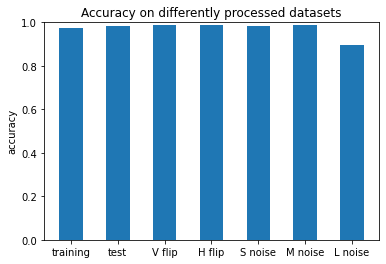

In [32]:
plt.bar([2,4,6,8,10,12,14], accuracy, 1, tick_label=["training","test","V flip","H flip","S noise", "M noise", "L noise"])
plt.ylabel("accuracy")
plt.ylim(0,1)
plt.title("Accuracy on differently processed datasets")
plt.savefig("testresults.pdf")

In [54]:
from tabulate import tabulate
percent_accuracy = [0] * 7
for i,acc in enumerate(accuracy):
  percent_accuracy[i] = str("{:.2f}".format(100. * acc)) + "%"
table = [["training","vanilla test","vertical flip","horizontal flip","weak noise", "medium noise", "strong noise"], percent_accuracy]
table = [[row[i] for row in table] for i in range(len(table[0]))]
print(tabulate(table, headers=["test set","accuracy"]))

test set         accuracy
---------------  ----------
training         97.41%
vanilla test     98.33%
vertical flip    98.93%
horizontal flip  98.63%
weak noise       98.46%
medium noise     99.00%
strong noise     89.44%
